### Run of the ABM

In this file we are going to run a simple version of the model from HSC to CLP and their descendant. We consider one type of MPP, and that this MPP as two possible descendants, CMP or CLP, the latter give birth to Dendritic_cell, NK, B_Cell, T_Cell.

We set the paremeters for HSC, ST-HSC, MPP with the data of the paper: **Fundamental properties of unperturbed haematopoiesis from stem cells in vivo**

*On average, per day, 1 out of 110 HSCs differentiates into an ST-HSC, and 1 out of 22 ST-HSCs differentiates into an MPP. At the MPP stage, considered a lymphoid–myeloid bifurcation point, we estimate that per day 1 out of 46 MPPs generates a CLP, while 1 MPP generates 4 CMPs. Given that the cell numbers also increase from HSC to ST-HSC and MPP, the efflux of cells exceeded influx in all of these compartments. To maintain compartment size, this flux difference is balanced by net proliferation.*

We try to set the parameters of B_cell, CLP and more global parameters using **Hematopoeisis in number**:

- Total number of hematopoeitic cell in a mouse = $1.7 * 10^10$ ( $1.6 * 10^10$ in blood, $4.5 * 10^8$ in bone marrow, $2.1 * 10^8$ in thymus, $7.6 * 10^7$ in lymph node, $2.1 * 10^8$ in the spleen)
- Total cell number across different compartment in a healthy mice: $10^4$ HSC, $10^5$ MPP, $10^6$ RPP, $10^8$ Granulomyeloids, $10^9$ Platelets, $10^10$ Erythrocytes, $10^8$ Lymphoids

Information found in supplementary material 1:

Definition of the information given in the paper:
- **Lifespan** = 1/Death rate = t1/2/ln(2)
- **Half life** = time for half to die 

Cell type parameters (Lifespan/ death rate):

- B Cell: Half-life = 24,3 days, lifespan = 35,00 days, death_rate = 0.03
- Granulomyeloids: half-life = 0.84, lifespan = 1.21 days, death_rate = 0.83
- Platelets: Half-life = 2.5 days, lifespan = 3.60 days, death_rate = 0.28
- Red blood cells: half-life = 24.3 days, lifespan = 35 days, death_rate = 0.03


We initialize different struct of our model TypeParameters, transition_matrix_0, TransitionDistribution.

- TypeParameters: 2 parmeters "time to death" (ttd) and "time to next division" (ttnd). They have the form of a vector of tuple of Float. Each tuple corresponds to the parameters of a cell type. The first float in each tuple is the mean ttd ot ttnd in number of days and the second float in each tuple is the standart deviation. We will draw ttd and ttnd for cell given distribution whith these parameters. 

- transition_matrix_0: This initialize a transition matrix. It is a squared matrix of size the number of cell type. The first row corresponds to the first cell type. transition_matrix_0[1,2] is the probability per day for a cell of type 1 to transition to type 2. transition_matrix_0[1,1] corresponds to the probability for a cell of type 1 to stay in type 1 per day. 

- TransitionDistribution: 1 parameter "time to next transition"(ttnt). It is a vector of vector. Each vector correspond to the distribution of transition time for each type. This distribution is of variable length and corresponds to the cdf of a geometric distribution, but the "times" step are 0.001. From these we can draw a random number between 0 and 1 and then we look for the first index at hich this random number is superior to, we divide this index by 1000 and get the time at which transition will occur.

In [19]:
using Pkg, FileIO, JLD2
Pkg.activate("/home/ajaeger/Documents/githubrepos/Stage/MyProject") #activation of the correct environment for the notebook


  Activating project at `~/Documents/githubrepos/Stage/MyProject`


In [3]:
Base.@kwdef struct TypeParameters
    # each of the properties has for length the number of type
    ttd::Vector{Tuple} = [(10000.0, 0.2), (330.0, 0.2), (70.0, 0.2), (60.0, 0.2), (1.1, 0.2)] #Time to death
    ttnd::Vector{Tuple} = [(110, 0.1), (1/0.042, 0.2), (0.25, 0.1), (86.66, 0.18), (10.9, 0.23)] # Time to next division
end


TypeParameters

In [3]:
#From data of supplemental material of Fundamental properties of unperturbed haematopoiesis from stem cells in vivo
#if we know n_HSC we can define relative compartment size. 
n_HSC = 1.0
n_STHSC = 2.9
n_MPP = 9.0
n_CMP = 39.0
n_CLP = 13.0

#Differentiation rate:
a_HSC_STHSC = 0.009
a_STHSC_MPP = 0.045
a_MPP_CMP = 3.992
a_MPP_CLP = 0.022

# Transition Matrix = [HSC, ST-HSC, MPP, CLP, CMP, ; ]

transition_matrix_0 = [(1 - a_HSC_STHSC/n_HSC) (a_HSC_STHSC/n_HSC) 0.0 0.0 0.0 ;   #HSC
                      0.0 (1 - a_STHSC_MPP/n_STHSC) (a_STHSC_MPP/n_STHSC) 0.0 0.0 ;       #ST-HSC
                      0.0 0.0 (1 - a_MPP_CLP/n_MPP - a_MPP_CMP/n_MPP) a_MPP_CLP/n_MPP a_MPP_CMP/n_MPP ;  #MPP
                      0.0 0.0 0.0 1.0 0.0 ;  #CLP
                      0.0 0.0 0.0 0.0 1.0 ;          #CMP
                      ]        

#residence time estimation: MPP 70 days, CLP 60 days (time spend in this differentiation state left by death or transition)

5×5 Matrix{Float64}:
 0.991  0.009     0.0        0.0         0.0
 0.0    0.984483  0.0155172  0.0         0.0
 0.0    0.0       0.554      0.00244444  0.443556
 0.0    0.0       0.0        1.0         0.0
 0.0    0.0       0.0        0.0         1.0

We initialize TypeParameters, TransitionDistribution for the model, here we use the default values of those stuct.

**n_tot** corresponds to the total number of cell at time 0.

**collection_t0** corresponds to number of cell and their type at time 0, of the form [(type, number of cell of this type), ...]

In [4]:
include("Initialization.jl")

typeparameters_0 = TypeParameters()

TypeParameters(Tuple[(10000.0, 0.2), (330.0, 0.2), (70.0, 0.2), (60.0, 0.2), (1.1, 0.2)], Tuple[(110, 0.1), (23.809523809523807, 0.2), (0.25, 0.1), (86.66, 0.18), (10.9, 0.23)])

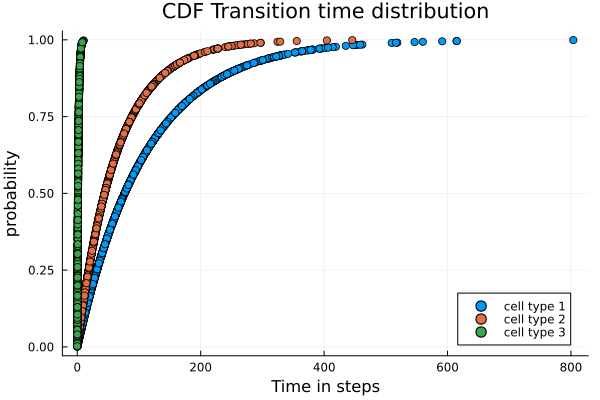

In [5]:
using Plots

ttnt1 = [draw_ttnt2(transition_matrix_0[1,:], 1) for _ in 1:1000]
ttnt2 = [draw_ttnt2(transition_matrix_0[2,:], 2) for _ in 1:1000]
ttnt3 = [draw_ttnt2(transition_matrix_0[3,:], 3) for _ in 1:1000]

plot([ttnt1[x][1] for x in 1:length(ttnt1)], [ttnt1[x][2] for x in 1:length(ttnt1)], seriestype=:scatter, label= "cell type 1", show = true, title ="CDF Transition time distribution", xlabel="Time in steps", ylabel = "probability")
plot!([ttnt2[x][1] for x in 1:length(ttnt2)], [ttnt2[x][2] for x in 1:length(ttnt2)], seriestype=:scatter, label= "cell type 2", show = true)
plot!([ttnt3[x][1] for x in 1: length(ttnt3)], [ttnt3[x][2] for x in 1:length(ttnt3)], seriestype=:scatter, label= "cell type 3", show = true)

The negative binomial distribution NB(r,p) can be represented as a compound Poisson distribution: Let N be a random variable, independent of the sequence, and suppose that N has a Poisson distribution with mean λ = −r ln(1 − p)

The geometric distribution (on { 0, 1, 2, 3, ... }) is a special case of the negative binomial distribution, with
    Geom ⁡ ( p ) = NB ⁡ ( 1 , p ) . {\displaystyle \operatorname {Geom} (p)=\operatorname {NB} (1,\,p).\,}

The Gamma-Poisson and the Negative Binomial distribution are mathematically identical, they just use different parametrizations. However, this can cause a lot of confusion, especially because the R

and Wikipedia again use two different parametrizations of the Negative Binomial:

    Wikipedia uses r

for the number of trials and p
for the number of failures
R
uses size for the number of trials and p′ for the number of successes, thus p′=1−p

    .

To convert from the Negative Binomial to the Gamma-Poisson parametrization μ=pr1−p=(1−p′)rp′α=1/r=1/size.

To convert from the Gamma-Poisson to the Negative Binomial parametrization: p=αμ1+αμp′=11+αμ
and r=size=1/α.

type_distribution_0 is a vector of vector, with one vector for each type and in each of these 2 distribution. The first distribution corresponds to the time to death and the second to the time to next division. We will draw from these distribution to attribute each cell a ttd and ttnd. It is possible to modify type_distribution when we run the model.

cell_collection_0 is a Vector of Vector, one vector corresponds to a cell. Each cell is attributed a type, ttd, ttnd, ttnt, as such [type, ttd, ttnd, ttnt]. This object is created based on collection_t0 and the dsitributions of ttd, ttnd, ttnt established above. 

These are initialized directly in the function initialize_model. This is just an instance of the output

In [5]:
n_states = 5
collection_t0 = [(1, 10), (2, 20)]
n_tot = sum([collection_t0[x][2] for x in eachindex(collection_t0)])

type_distribution_0 = initialize_distributions(typeparameters_0, n_states)
cell_collection_0 = initialize_collection(type_distribution_0, transition_matrix_0, collection_t0, n_tot)

30-element Vector{Vector{Any}}:
 [1, 7670.094409401728, 87.43586573592341, 39.70182437336699]
 [1, 8510.443448041508, 106.92736354355233, 1.8281816701126847]
 [1, 8493.787214231123, 128.9108687684956, 58.253222231688774]
 [1, 10196.240989170024, 110.23023529877003, 180.22161066245934]
 [1, 10274.367418153772, 94.60171260358048, 143.1374534077736]
 [1, 7230.259702080922, 99.60727501165307, 92.35355641698196]
 [1, 10761.26699642636, 103.16731080072886, 404.15295224611634]
 [1, 8004.681250244069, 104.6527844327796, 39.485790249299995]
 [1, 10948.21919662064, 131.20778773750666, 244.06803070415774]
 [1, 9654.943926843383, 99.37829495357786, 34.17389783733763]
 ⋮
 [2, 312.14696710502153, 27.320192200633752, 146.04049148317102]
 [2, 372.13066480317184, 21.57670909512688, 0.39651337219753513]
 [2, 408.1864260947832, 18.873286641446583, 11.174566002011572]
 [2, 230.30116265259156, 29.372388550345622, 4.5343061901625985]
 [2, 466.26424619231216, 24.773334211622867, 3.8559519765385812]
 [2, 378.

The following cell must be modified, rerun for each run of the model, to avoid overwriting data, and to reinitilize
death_file defines the location and name of the txt file where 

In [6]:
death_file = "/home/ajaeger/Documents/githubrepos/Stage/test_file"
modelparameters_0 = initialize_modelparameters(100, n_states, death_file, transition_matrix_0, typeparameters_0)

life = initialize_model(collection_t0, transition_matrix_0, modelparameters_0, typeparameters_0, n_tot, ms)

StandardABM with 30 agents of type HematopoeiticCell
 space: nothing (no spatial structure)
 scheduler: ms
 properties: s, n_steps, activation_rate, adata, deaths, nbr_state, death_file, matrix, pool, ttnd_parameters, ttnt_parameters, ttd_parameters, var_ttnd, var_ttnt, var_ttd

The following cell returns a DataFrame containing the parameters of the cells at time 0 in the model life.

In [7]:
df = DataFrame(id = Any[], type = Any[], ttnd = Any[], ttnt = Any[], ttd = Any[], state = Any[], time_next_event = Any[])
for cell in 1:n_tot
    df = push!(df, [life[cell].id life[cell].type life[cell].ttnd life[cell].ttnt life[cell].ttd life[cell].state life[cell].time_next_event])
end
df

Row,id,type,ttnd,ttnt,ttd,state,time_next_event
,Any,Any,Any,Any,Any,Any,Any
1,1,1,94.9844,9.29419,9719.8,Transition,9.29419
2,2,1,109.235,110.307,10727.8,Division,109.235
3,3,1,100.765,32.7548,8161.15,Transition,32.7548
4,4,1,89.1402,88.2617,11053.5,Transition,88.2617
5,5,1,101.533,333.968,9606.09,Division,101.533
6,6,1,105.222,32.9452,7556.23,Transition,32.9452
7,7,1,102.483,34.7827,9696.96,Transition,34.7827
8,8,1,117.828,191.322,7729.06,Division,117.828
9,9,1,102.437,247.153,13009.6,Division,102.437


In [8]:
data = custom_run!(life, life_step!, model_step!, n)

types = [1, 2, 3, 4, 5]

5-element Vector{Int64}:
 1
 2
 3
 4
 5

In [32]:
show(data, allrows=true, allcols=true)

343×3 DataFrame
 Row │ id     type   lineage                           
     │ Int64  Int64  Array…                            
─────┼─────────────────────────────────────────────────
   1 │     1      1  Float64[]
   2 │     2      2  [2.0, 92.06, 1.0]
   3 │     5      1  Float64[]
   4 │     6      1  Float64[]
   5 │     7      1  Float64[]
   6 │     9      1  Float64[]
   7 │   135      5  [29.0, 20.529, 2.0, 41.0, 41.913…
   8 │   147      2  [31.0, 40.843, 2.0, 68.0, 69.203…
   9 │   148      2  [68.0, 69.203, 2.0]
  10 │   152      2  [72.0, 70.14, 2.0]
  11 │   155      2  [49.0, 49.1, 2.0, 90.0, 73.555, …
  12 │   156      2  [90.0, 73.555, 2.0]
  13 │   160      2  [79.0, 74.526, 2.0]
  14 │   166      2  [89.0, 75.511, 2.0]
  15 │   171      2  [37.0, 45.034, 2.0, 80.0, 79.515…
  16 │   174      2  [105.0, 80.669, 2.0]
  17 │   176      5  [122.0, 81.356, 2.0, 176.0, 97.3…
  18 │   177      2  [32.0, 38.474, 2.0, 62.0, 58.91,…
  19 │   178      2  [111.0, 81.312, 2.0]
  20

In [5]:
include("data_analysis.jl")

#cells_number = precision_cell_count(data, death_file,types, 100, n_tot,0.01)

get_adj_list_all_cells2 (generic function with 1 method)

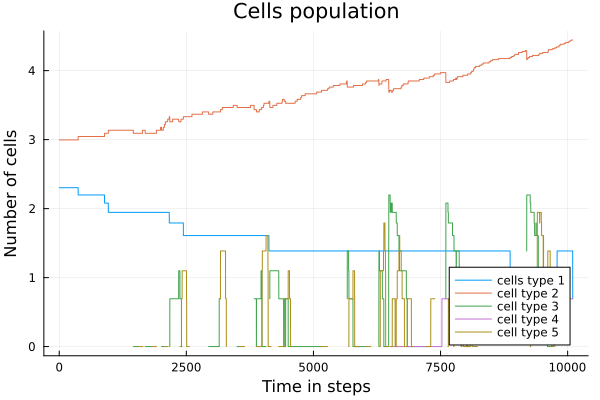

In [28]:
using Plots

plot(1:length(cells_number[1]), log.(cells_number[1]), label= "cells type 1", show = true, title ="Cells population", xlabel="Time in steps", ylabel = "Number of cells")
plot!(1:length(cells_number[2]), log.(cells_number[2]), label= "cell type 2", show = true)
plot!(1:length(cells_number[3]), log.(cells_number[3]), label= "cell type 3", show = true)
plot!(1:length(cells_number[4]), log.(cells_number[4]), label= "cell type 4", show = true)
plot!(1:length(cells_number[5]), log.(cells_number[5]), label= "cell type 5", show = true)

Modify the function division so that the full lineage is saved only for one of the daughter cell, for the other one we save only the mother cell info ! 

This will reduce drastically the size of the outputs file. 

### Estimation of time of run and size of files generated

We are going to study the mean time of run for different number of cell at t = 0, and differnt length of run, but also in function of the mean number of cell during the run.

first lets run multiple times the model for a different number of steps. We input the following command

``````
    bash ABM_run.sh -p 0 -s 1 -e 10 -steps 10
    bash ABM_run.sh -p 0 -s 11 -e 20 -steps 30
    bash ABM_run.sh -p 0 -s 21 -e 30 -steps 50
    bash ABM_run.sh -p 0 -s 31 -e 40 -steps 80
    bash ABM_run.sh -p 0 -s 41 -e 50 -steps 100
    bash ABM_run.sh -p 0 -s 51 -e 60 -steps 150
    bash ABM_run.sh -p 0 -s 61 -e 70 -steps 250
``````

For each of these run the parameters were:
```
transition_matrix_0 = [0.991 0.009 0.0 0.0 0.0; 0.0 0.9844827586206897 0.015517241379310345 0.0 0.0; 0.0 0.0 0.554 0.0024444444444444444 0.44355555555555554; 0.0 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 0.0 1.0]
collection_t0 = [(1,10), (2,20)]
ttd_0 = [(10000.0, 0.2), (330.0, 0.2), (70.0, 0.2), (60.0, 0.2), (1.1, 0.2)]
ttnd_0 = [(110, 0.1), (1/0.042, 0.2), (0.25, 0.1), (86.66, 0.18), (10.9, 0.23)] 
```
We recorded the runtime below are the real of command bash time for the seven different numbe of steps.


In [6]:
# time in seconds
time1 = [7.887, 8.228, 8.003, 7.995, 8.566, 7.696, 8.071, 7.677, 8.090, 8.157]
time2 = [8.144, 7.956, 7.983, 8.298, 8.981, 8.416, 8.090, 8.408, 11.943, 8.387]
time3 = [8.029, 8.836, 9.241, 9.116, 9.186, 9.056, 8.275, 8.019, 7.966, 8.133]
time4 = [8.050, 8.071, 8.100, 7.995, 8.089, 8.048, 8.104, 8.053, 8.166, 8.162]
time5 = [20.573, 8.247, 9.305, 8.984, 8.686, 8.473, 8.385, 8.750, 8.638, 8.366]
time6 = [8.087, 8.358, 12.410, 8.694, (2*60+18.766), 7.886, (50*60+4.619), 9.945, (43*60+14.354), 10.141]

10-element Vector{Float64}:
    8.087
    8.358
   12.41
    8.694
  138.766
    7.886
 3004.619
    9.945
 2594.354
   10.141

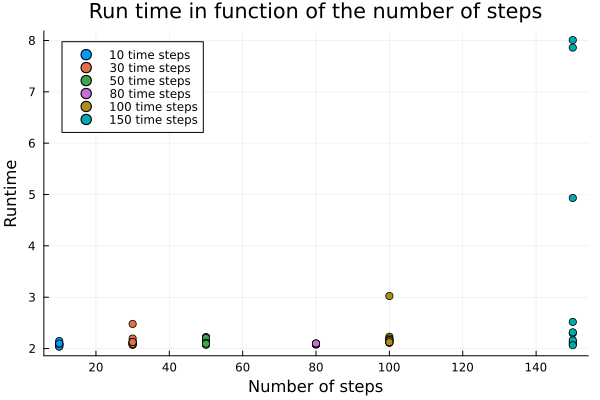

In [7]:

using Plots

plot([10 for _ in eachindex(time1)], log.(time1), seriestype=:scatter, label= "10 time steps", show = true, title ="Run time in function of the number of steps", xlabel="Number of steps", ylabel = "Runtime")
plot!([30 for _ in eachindex(time2)], log.(time2), seriestype=:scatter, label= "30 time steps")
plot!([50 for _ in eachindex(time3)], log.(time3), seriestype=:scatter, label= "50 time steps")
plot!([80 for _ in eachindex(time4)], log.(time4), seriestype=:scatter, label= "80 time steps")
plot!([100 for _ in eachindex(time5)], log.(time5), seriestype=:scatter, label= "100 time steps")
plot!([150 for _ in eachindex(time6)], log.(time6), seriestype=:scatter, label= "150 time steps")

We want to be able to access the information of cell count easily because the operation of precision_cell_count can be quite time consumming we don't want to have to repeat this operation more than necessary. Therefore we created the function store_cellcount, which will perform precision cell count on indicated files and store the results in a jld2 file as a Dict of Dict. The big Dict has for keys the index of the file to which is associated a Dict which is the output of precision_cell_count (so the length of the latter Dic depends on the number of time steps in the run and the precision wanted). 
This function takes as input a path in the form of a string which indicate where the files to analyse are, an output path, the list of the index of the files on which we want to compute. We must also provide parameters needed for precision_cell_count. 

In order not to get lost here is a mapping out of the architecture of my files:
```
----Stage
     |
     |----MyProject
     |      |
     |      |----Manifest.toml
     |      |----Project.toml
     |
     |----Script
     |
     |----log
     |     |
     |     |----Param_*
     |           |
     |           |----run_*
     |
     |
     |----Param_*
     |      |
     |      |----parameters_file_*.txt
     |      |----Data
     |      |      |
     |      |      |----output_death_run_*
     |      |      |----output_run_*
     |      |
     |      |----Analysis
     |             |
     |             |----Count
     |
     |----Param_**
```

In [9]:
using DataFrames
using CSV

#cell count
include("data_analysis.jl")
file = "/home/ajaeger/Documents/githubrepos/Stage/Param_0"
DictofDict = Dict{Int, Dict}(x => Dict() for x in 1:60)
for i in 1:60
    file = "/home/ajaeger/Documents/githubrepos/Stage/Param_0/output_run_"*string(i)
    death_file = "/home/ajaeger/Documents/githubrepos/Stage/Param_0/output_death_run_"*string(i)
    
    nbr_cell = [10, 30, 50, 80, 100, 150]
    if i in 1:9
        last_time_step = nbr_cell[1]
    elseif i in 10:20
        print("yes")
        last_time_step = nbr_cell[2]
    elseif i in 21:30
        last_time_step = nbr_cell[3]
    elseif i in 31:40
        last_time_step = nbr_cell[4]
    elseif i in 41:50
        last_time_step = nbr_cell[5]
    elseif i in 51:60
        last_time_step = nbr_cell[6]
    end
    print("last_time_step ", last_time_step)
    DictofDict[i] = precision_cell_count(file, death_file, [1, 2, 3, 4, 5], last_time_step, 30, 1.0)
    print(" ", i, "\n")
end

last_time_step 10 1
last_time_step 10 2
last_time_step 10 3
last_time_step 10 4
last_time_step 10 5
last_time_step 10 6
last_time_step 10 7
last_time_step 10 8
last_time_step 10 9
yeslast_time_step 30 10
yeslast_time_step 30 11
yeslast_time_step 30 12
yeslast_time_step 30 13
yeslast_time_step 30 14
yeslast_time_step 30 15
yeslast_time_step 30 16
yeslast_time_step 30 17
yeslast_time_step 30 18
yeslast_time_step 30 19
yeslast_time_step 30 20
last_time_step 50 21
last_time_step 50 22
last_time_step 50 23
last_time_step 50 24
last_time_step 50 25
last_time_step 50 26
last_time_step 50 27
last_time_step 50 28
last_time_step 50 29
last_time_step 50 30
last_time_step 80 31
last_time_step 80 32
last_time_step 80 33
last_time_step 80 34
last_time_step 80 35
last_time_step 80 36
last_time_step 80 37
last_time_step 80 38
last_time_step 80 39
last_time_step 80 40
last_time_step 100 41
last_time_step 100 42
last_time_step 100 43
last_time_step 100 44
last_time_step 100 45
last_time_step 100 46
last

ArgumentError: ArgumentError: "/home/ajaeger/Documents/githubrepos/Stage/Param_0/output_run_57" is not a valid file or doesn't exist

In [20]:
save("test_cell_count.jld2","DictofDict",DictofDict)

In [21]:
load("test_cell_count.jld2")["DictofDict"]

Dict{Int64, Dict} with 60 entries:
  5  => Dict(5=>[0, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0], 4=>[0, 0, 0, 0, 0, 0, 0, …
  56 => Dict(5=>[0, 0, 0, 1, 0, 0, 0, 0, 0, 0  …  0, 0, 6, 22, 13, 460, 561, 56…
  16 => Dict(5=>[0, 0, 0, 1, 0, 0, 0, 1, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]…
  20 => Dict(5=>[0, 0, 0, 0, 0, 0, 1, 1, 0, 0  …  1, 0, 0, 0, 0, 0, 0, 0, 0, 0]…
  35 => Dict(5=>[0, 0, 1, 0, 0, 0, 0, 1, 0, 1  …  0, 0, 0, 0, 5, 16, 1, 1, 0, 0…
  55 => Dict(5=>[0, 0, 0, 0, 0, 0, 0, 1, 0, 0  …  0, 0, 0, 0, 0, 1, 16, 20, 0, …
  60 => Dict{Any, Any}()
  30 => Dict(5=>[0, 0, 0, 0, 0, 1, 0, 0, 0, 1  …  2, 0, 0, 0, 0, 1, 1, 1, 0, 0]…
  19 => Dict(5=>[0, 0, 1, 1, 0, 0, 0, 0, 0, 1  …  0, 0, 0, 1, 0, 1, 1, 1, 0, 0]…
  32 => Dict(5=>[0, 0, 0, 0, 0, 0, 0, 1, 0, 0  …  2, 2, 1, 0, 0, 0, 0, 0, 0, 0]…
  49 => Dict(5=>[0, 0, 0, 0, 0, 0, 0, 1, 1, 0  …  6, 60, 4, 1, 0, 0, 0, 0, 0, 0…
  6  => Dict(5=>[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0], 4=>[0, 0, 0, 0, 0, 0, 0, …
  45 => Dict(5=>[0, 0, 0, 0, 0, 1, 0, 0, 0, 1  … 

In [ ]:
#Evolution of the number of cell of type 1 for the different number of step

In [ ]:
#Evolution of the number of cell of type 2 for the different number of step

In [ ]:
#Evolution of the number of cell of type 3 for the different number of step

In [ ]:
Dic

We see that from 100 steps, we see very diffferent time for the run, most under the minute but 2 which last more than 40 min. We assume that this difference is caused by the occurence of an explosion of the cell population. Now we want to know if it's the number of cell or the number of operations which dictates the time of a run. We assume it's the operations.

To test the different option, I am going to test :
- evolving for a short time a wide population with a non zero history (so we need to save all the cells infos at the end, and the current step of the model, we want the lineage size to be realistic that's why we don't just initialize a large number of cell).
- we consider a population with short time to divison transition and death that we run for a short time

Not full proof, but what we want is an estimation of the maximum time it could take. We need this information to compute on the cluster otherwise the run willlikely be interrupted before its hand. 

#### What ahs been done! (yyyeeaaahhh)
- verifier si fonctionne quand temps inférieur au jour: oui ça fonctionne !
- corriger fonction d'initialisation pour qu'elle ne prenne plus le floor du prochain event
- recommenter les fonctions : c'est fait
- modification pour que tout soit en continu
- modification du lineage des cellules (seulement une cellule fille hérite de tous le lignage l'autre hérite uniquement de l'identité de la cellule mère)
- calculer plus rapidement les distributions. EN FAIT on va tout passer en continu et utiliser une distrib exponentielle. **ERREUR** sur le temps de distrib utilisé car je normalise alors que j'ai pas du tout le droit pour le type 1 avec un petite proba de succès. 
- tracer populations en fonction du temps: ca marche

#### What to do know?
- estimer le temps de run et la taille des données générées
- tester modele sur long temps
- relire article modelo niche
- écrire le notebook: c'est en cours
- trouver package pour dessiner des arbres temporellement coherent. 
- faire en sorte que les paramètres du modèles soit enregistrer dans un fichier, aussi enregistrer si les paramètres sont modifier pendant la simu! pas seuleemnt au début. 
- stocker les données final, plot, numbers, dans un fichier. 
- ecrire fonctions pour redraw les différents temps de toutes les cellules vivantes en fonction de leur type
- écrire une fonction de création de MPP à différents temps 
- prédestiné des cellules souches

**Analyse des données**
- ecrire fonction d'analyse des données pour simuler le labelling d'une population
- faire des plots de l'espace des paramètres
- trouver un critères pour la stabilité et pour la comparer ? à quelle vitesse devient stable ? 
- reecrire les fonctions de collect from lineage pour nouvelle facon dont stocké 

**Pour aller plus loin**
- peut on prévoir mathématiquement le niveau stable de chacune des populations
 